# Logistic Regression Modelling

In [249]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [250]:
df = pd.read_excel('Cleaned_Data.xlsx')
df

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Complain,Age,Family_Size,Total_Spent,BuyingPower
0,0,1826,1970,Graduation,Divorced,84835.0,0,0,2014-06-16,0,...,4,4,6,1,1,0,54,1,198.333333,0.002338
1,1,1,1961,Graduation,Single,57091.0,0,0,2014-06-15,0,...,7,3,7,5,1,0,63,1,96.166667,0.001684
2,2,10476,1958,Graduation,Married,67267.0,0,1,2014-05-13,0,...,3,2,5,2,0,0,66,3,41.833333,0.000622
3,3,1386,1967,Graduation,Together,32474.0,1,1,2014-11-05,0,...,1,0,2,7,0,0,57,4,1.833333,0.000056
4,4,5371,1989,Graduation,Single,21474.0,1,0,2014-08-04,0,...,3,1,2,7,1,0,35,2,15.166667,0.000706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,2235,10142,1976,PhD,Divorced,66476.0,0,1,2013-07-03,99,...,5,2,11,4,0,0,48,2,114.833333,0.001727
2230,2236,5263,1977,TwoN_Cycle,Married,31056.0,1,0,2013-01-22,99,...,1,0,3,8,0,0,47,3,9.166667,0.000295
2231,2237,22,1976,Graduation,Divorced,46310.0,1,0,2012-03-12,99,...,6,1,5,8,0,0,48,2,51.500000,0.001112
2232,2238,528,1978,Graduation,Married,65819.0,0,0,2012-11-29,99,...,5,4,10,3,0,0,46,2,230.500000,0.003502


In [251]:
df = df[[
    'Age',
    'Marital_Status',
    'Education',
    'Income', 
    'Kidhome', 
    'Teenhome',
    'Recency',
    'MntFishProducts', 
    'MntMeatProducts', 
    'MntFruits', 
    'MntSweetProducts', 
    'MntWines', 
    'MntGoldProds',
    'NumDealsPurchases',
    'NumWebPurchases',
    'NumCatalogPurchases',
    'NumStorePurchases',
    'NumWebVisitsMonth',
    'Family_Size',
    'Total_Spent',
    'BuyingPower',
    'Response',
    'Complain'
    ]]

In [252]:
def one_hot_encode(data, column, suffix=''):
    encoded = pd.get_dummies(data[column], drop_first= True)
    data = data.drop(column, axis = 1)
    data = data.join(encoded, lsuffix='_data', rsuffix='_encoded')
    # data = data.join(encoded)
    return data

df = one_hot_encode(df, 'Marital_Status')
df = one_hot_encode(df, 'Education')

df

,Age,Income,Kidhome,Teenhome,Recency,MntFishProducts,MntMeatProducts,MntFruits,MntSweetProducts,MntWines,...,Response,Complain,Married,Single,Together,Widow,Graduation,Master,PhD,TwoN_Cycle
0,54,84835.0,0,0,0,111,379,104,189,189,...,1,0,False,False,False,False,True,False,False,False
1,63,57091.0,0,0,0,7,64,5,0,464,...,1,0,False,True,False,False,True,False,False,False
2,66,67267.0,0,1,0,15,59,11,2,134,...,0,0,True,False,False,False,True,False,False,False
3,57,32474.0,1,1,0,0,1,0,0,10,...,0,0,False,False,True,False,True,False,False,False
4,35,21474.0,1,0,0,11,24,16,0,6,...,1,0,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,48,66476.0,0,1,99,47,126,18,48,372,...,0,0,False,False,False,False,False,False,True,False
2230,47,31056.0,1,0,99,3,13,10,8,5,...,0,0,True,False,False,False,False,False,False,True
2231,48,46310.0,1,0,99,15,88,2,5,185,...,0,0,False,False,False,False,True,False,False,False
2232,46,65819.0,0,0,99,149,701,38,165,267,...,0,0,True,False,False,False,True,False,False,False


In [253]:
X = df.drop('Response', axis=1)
y = df['Response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [254]:
scaler = PolynomialFeatures()
X_train = scaler.fit_transform(X_train)

In [255]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
train_preds = clf.predict(X_train)
preds = clf.predict(scaler.transform(X_test))

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Train Scores

In [256]:
acc = accuracy_score(y_train, train_preds)
prec = precision_score(y_train, train_preds)
rec = recall_score(y_train, train_preds)
f1 = f1_score(y_train, train_preds)
auc = roc_auc_score(y_train, train_preds)

In [257]:
print("Accuracy: %.4f" % acc)
print("Precision: %.4f" % prec)
print("Recall: %.4f" % rec)
print("F1: %.4f" % f1)
print("AUC: %.4f" % auc)

Accuracy: 0.8522
Precision: 0.5070
Recall: 0.1552
F1: 0.2376
AUC: 0.5644


## Test Scores

In [258]:
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc = roc_auc_score(y_test, preds)

In [259]:
print("Accuracy: %.4f" % acc)
print("Precision: %.4f" % prec)
print("Recall: %.4f" % rec)
print("F1: %.4f" % f1)
print("AUC: %.4f" % auc)

Accuracy: 0.8584
Precision: 0.5556
Recall: 0.2020
F1: 0.2963
AUC: 0.5870


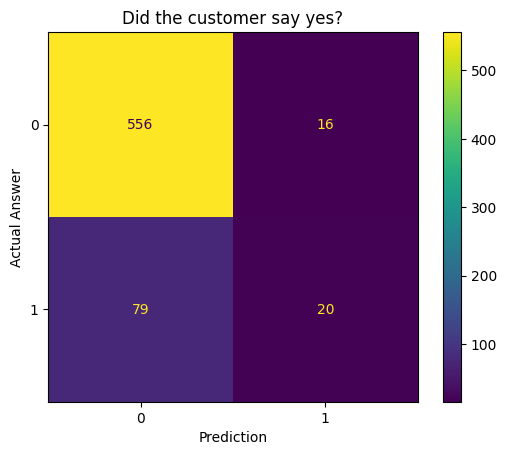

In [260]:
cm = confusion_matrix(y_test, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.title('Did the customer say yes?')
plt.xlabel('Prediction')
plt.ylabel('Actual Answer')
plt.show()